In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import json
import os

In [2]:
# Load X_scaled dan y
X_scaled = pd.read_csv(r"C:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\data\processed\X_scaling.csv")
y = pd.read_csv(r"C:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\data\processed\ys.csv").squeeze()

print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)


X_scaled shape: (2768674, 78)
y shape: (2768674,)


In [3]:
import pandas as pd
import numpy as np

# Hitung korelasi absolut
corr_matrix = X_scaled.corr().abs()

# Ambil upper triangle
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Tentukan fitur yang akan dihapus (korelasi > 0.9)
to_drop = [c for c in upper_tri.columns if any(upper_tri[c] > 0.9)]
print(f"🔹 Dihapus {len(to_drop)} fitur berkorelasi tinggi.")

# Buat list untuk dataframe
rows = []
for col in to_drop:
    # Ambil semua fitur yang berkorelasi tinggi dengan col
    high_corr = upper_tri[col][upper_tri[col] > 0.9]
    for correlated_feature, corr_value in high_corr.items():
        rows.append({
            "Fitur Dihapus": col,
            "Fitur Berkorelasi Tinggi": correlated_feature,
            "Korelasi": round(corr_value, 2)
        })

# Buat dataframe rapi
df_corr_report = pd.DataFrame(rows)

# Pastikan hanya menampilkan 32 fitur yang dihapus
df_corr_report = df_corr_report[df_corr_report["Fitur Dihapus"].isin(to_drop)]

# Reset index agar rapi
df_corr_report.reset_index(drop=True, inplace=True)

# Tampilkan seluruh tabel
pd.set_option('display.max_rows', None)  # tampilkan semua baris
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(df_corr_report)

# Simpan ke CSV atau Excel
df_corr_report.to_csv("fitur_berkorelasi_tinggi_lengkap.csv", index=False)
# df_corr_report.to_excel("fitur_berkorelasi_tinggi_lengkap.xlsx", index=False)


🔹 Dihapus 32 fitur berkorelasi tinggi.
                  Fitur Dihapus     Fitur Berkorelasi Tinggi  Korelasi
0        Total_Backward_Packets            Total_Fwd_Packets      1.00
1   Total_Length_of_Bwd_Packets            Total_Fwd_Packets      1.00
2   Total_Length_of_Bwd_Packets       Total_Backward_Packets      0.99
3        Fwd_Packet_Length_Mean        Fwd_Packet_Length_Max      0.91
4         Fwd_Packet_Length_Std        Fwd_Packet_Length_Max      0.98
5         Fwd_Packet_Length_Std       Fwd_Packet_Length_Mean      0.90
6        Bwd_Packet_Length_Mean        Bwd_Packet_Length_Max      0.96
7         Bwd_Packet_Length_Std        Bwd_Packet_Length_Max      0.99
8         Bwd_Packet_Length_Std       Bwd_Packet_Length_Mean      0.95
9                  Flow_IAT_Max                 Flow_IAT_Std      0.94
10                Fwd_IAT_Total                Flow_Duration      1.00
11                  Fwd_IAT_Std                 Flow_IAT_Max      0.92
12                  Fwd_IAT_Max       

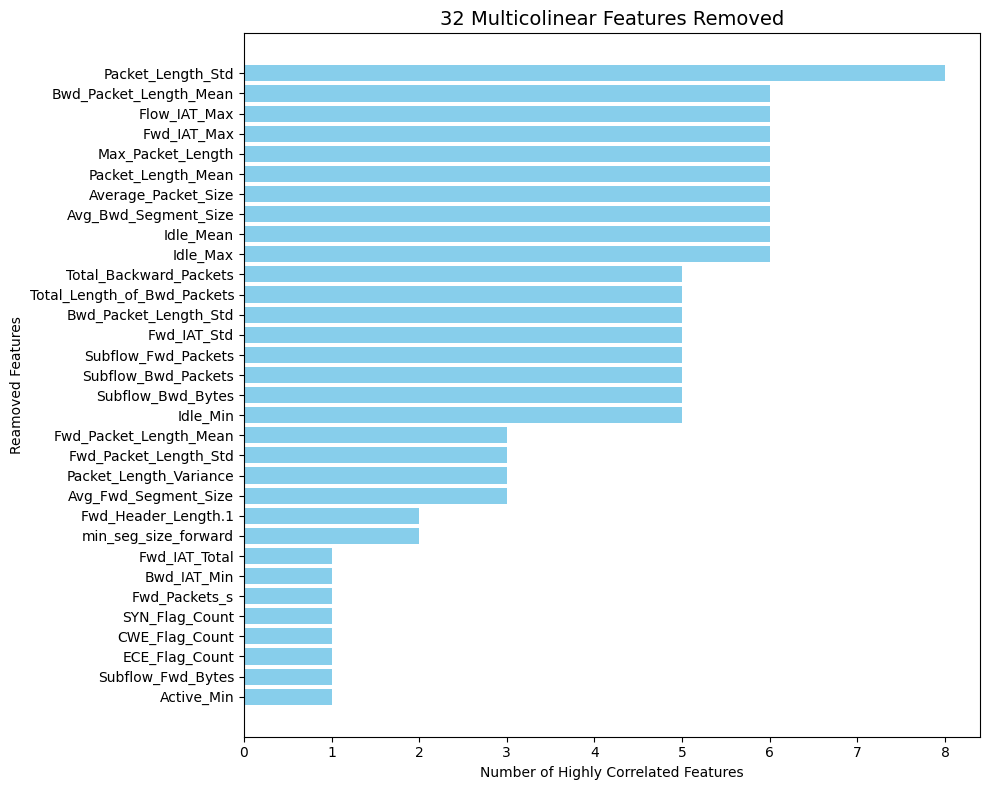

In [13]:
import matplotlib.pyplot as plt

# Hitung jumlah fitur lain yang berkorelasi tinggi dengan setiap fitur yang dihapus
corr_count = {}
for col in to_drop:
    high_corr = corr_drop[col][corr_drop[col] > 0.9]
    corr_count[col] = len(high_corr)

# Urutkan fitur berdasarkan jumlah korelasi
sorted_corr_count = dict(sorted(corr_count.items(), key=lambda x: x[1], reverse=True))

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_corr_count.keys()), list(sorted_corr_count.values()), color='skyblue')
plt.xlabel("Number of Highly Correlated Features")
plt.ylabel("Reamoved Features")
plt.title("32 Multicolinear Features Removed", fontsize=14)
plt.gca().invert_yaxis()  # fitur terbanyak di atas
plt.tight_layout()
plt.show()


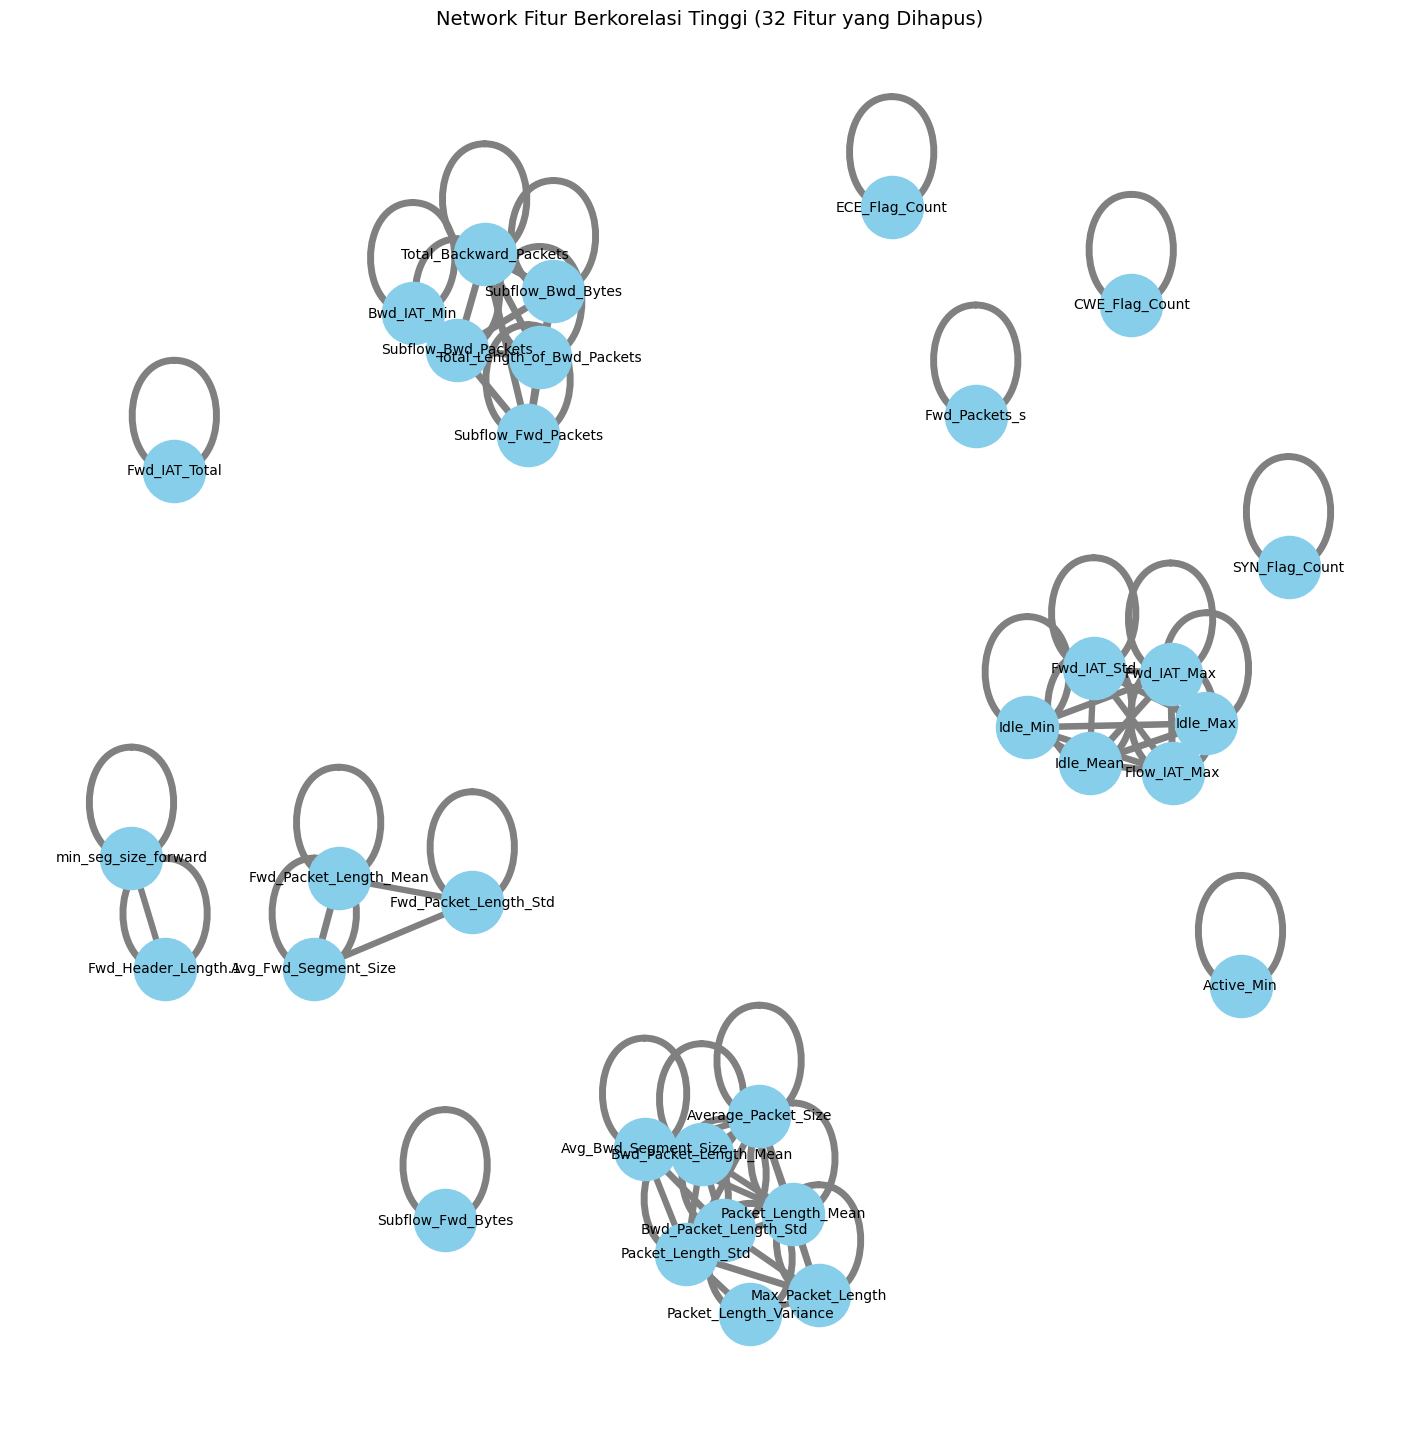

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Subset fitur yang dihapus
X_drop_subset = X_scaled[to_drop]
corr_drop = X_drop_subset.corr()

# Buat graph
G = nx.Graph()
for i in to_drop:
    high_corr = corr_drop[i][corr_drop[i] > 0.9]
    for j, val in high_corr.items():
        G.add_edge(i, j, weight=val)

# Plot
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.5, seed=42)  # tata letak rapi
edges = G.edges()
weights = [G[u][v]['weight']*5 for u,v in edges]  # tebal garis sesuai korelasi

nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', width=weights, font_size=10)
plt.title("Network Fitur Berkorelasi Tinggi (32 Fitur yang Dihapus)", fontsize=14)
plt.show()


In [10]:
# Hapus fitur multikolinear (korelasi > 0.9)
corr_matrix = X_scaled.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [c for c in upper_tri.columns if any(upper_tri[c] > 0.9)]
X_reduced = X_scaled.drop(columns=to_drop)
print(f"🔹 Dihapus {len(to_drop)} fitur berkorelasi tinggi.")

🔹 Dihapus 32 fitur berkorelasi tinggi.


In [11]:
from sklearn.feature_selection import VarianceThreshold

# Filter varians rendah
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_reduced)  # <-- wajib fit dulu

# Fitur yang dipertahankan
kept_cols = X_reduced.columns[selector.get_support()]

# Fitur yang dibuang
dropped_cols = X_reduced.columns[~selector.get_support()]

# Update X_reduced
X_reduced = X_reduced[kept_cols]

print(f"{len(kept_cols)} fitur dipertahankan setelah filter varians rendah.")
print(f"{len(dropped_cols)} fitur dibuang karena varians rendah:")
print(list(dropped_cols))


36 fitur dipertahankan setelah filter varians rendah.
10 fitur dibuang karena varians rendah:
['Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'RST_Flag_Count', 'Fwd_Avg_Bytes_Bulk', 'Fwd_Avg_Packets_Bulk', 'Fwd_Avg_Bulk_Rate', 'Bwd_Avg_Bytes_Bulk', 'Bwd_Avg_Packets_Bulk', 'Bwd_Avg_Bulk_Rate']


In [18]:
# Buang fitur dengan varians rendah (opsional)
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_reduced)
kept_cols = X_reduced.columns[selector.get_support()]
X_reduced = X_reduced[kept_cols]
print(f"🧹 {len(kept_cols)} fitur dipertahankan setelah filter varians rendah.")

🧹 36 fitur dipertahankan setelah filter varians rendah.


[LightGBM] [Info] Number of positive: 2242880, number of negative: 525794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7420
[LightGBM] [Info] Number of data points in the train set: 2768674, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607


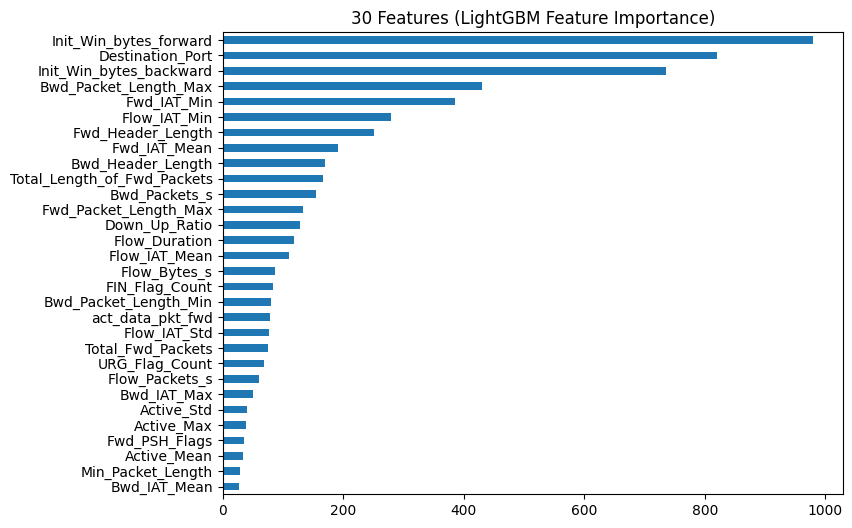

In [15]:
# Feature Importance (LightGBM)
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_reduced, y)

importances = pd.Series(lgbm.feature_importances_, index=X_reduced.columns)
importances = importances.sort_values(ascending=False)

# Plot top 30 fitur
top_features = importances.head(30)
plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("30 Features (LightGBM Feature Importance)")
plt.show()

selected_features = importances.head(30).index.tolist()
X_selected = X_reduced[selected_features]

[LightGBM] [Info] Number of positive: 2242880, number of negative: 525794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7420
[LightGBM] [Info] Number of data points in the train set: 2768674, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607


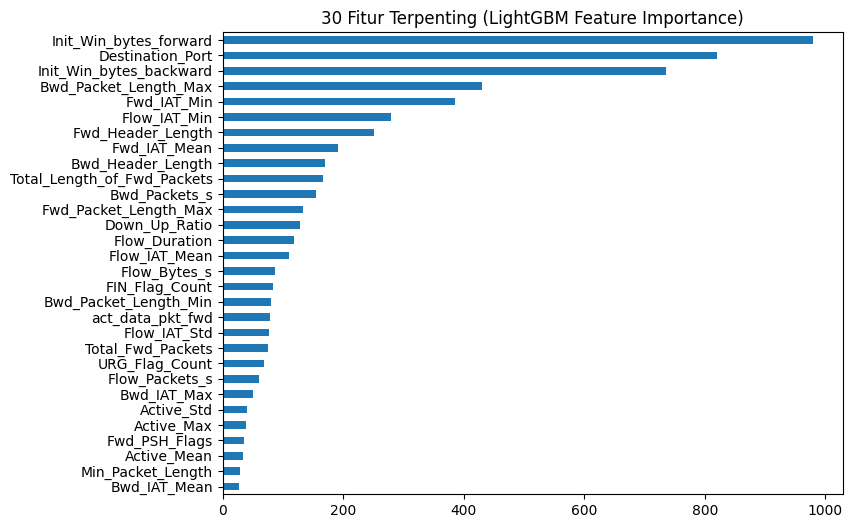

In [11]:
# Feature Importance (LightGBM)
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_reduced, y)

importances = pd.Series(lgbm.feature_importances_, index=X_reduced.columns)
importances = importances.sort_values(ascending=False)

# Plot top 30 fitur
top_features = importances.head(30)
plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("30 Fitur Terpenting (LightGBM Feature Importance)")
plt.show()

selected_features = importances.head(30).index.tolist()
X_selected = X_reduced[selected_features]

In [12]:
# Cek VIF (opsional)
vif_data = pd.DataFrame()
vif_data["feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i)
                   for i in range(X_selected.shape[1])]
print("Top 10 fitur menurut VIF:")
print(vif_data.sort_values(by="VIF", ascending=False).head(10))

Top 10 fitur menurut VIF:
          feature        VIF
7    Fwd_IAT_Mean  90.603957
14  Flow_IAT_Mean  80.218454
19   Flow_IAT_Std  34.161174
4     Fwd_IAT_Min  26.117009
5    Flow_IAT_Min  22.785056
25     Active_Max  15.216908
29   Bwd_IAT_Mean  11.373454
27    Active_Mean   7.129593
23    Bwd_IAT_Max   5.252075
13  Flow_Duration   5.121589


In [15]:
# Pastikan folder processed di lokasi yang benar
os.makedirs(r"C:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\data\processed", exist_ok=True)

# Simpan selected_features ke JSON di folder data/processed
with open(r"C:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\data\processed\selected_features.json", "w") as f:
    json.dump(selected_features, f)

print("selected_features.json berhasil disimpan di data/processed")


selected_features.json berhasil disimpan di data/processed


In [23]:
# Ambil kolom yang terpilih
X_selected = X_scaled[selected_features]

# Split test 20%
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Split train/val 80:20 dari sisa
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Train: (1771951, 30)
Val  : (442988, 30)
Test : (553735, 30)
